In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, RepeatVector
from tensorflow.keras.models import Model,load_model

# 1. Upload and show test data

### (train data: 2020/12/1 ~ 2020/12/10, test data: 2021/3/14)

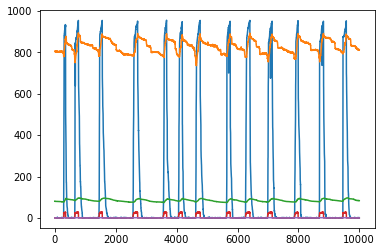

In [2]:
UsingFeatures = ['pres_cm_in','pres_mr','temp_cm_oil','curr_u','valv_1']

data = pd.read_csv('./data/205train/205train_cmsd_tc1_2021_03_14.csv')
data = data[UsingFeatures]
    
plt.plot(data[0:10000])
plt.show()

# 2. Preprocessing to input to the model

In [3]:
def moving_window(data,sequence_num,step):
    X_train = []
    for i in range(0,len(data)-sequence_num,step):
        X_train.append(data[i:i+sequence_num])
    
    X_train = np.array(X_train)
    return X_train

def normalization(data):
    pres_cm_in_max = 1000
    pres_cm_in_min = 0
    pres_mr_max = 900
    pres_mr_min = 600
    temp_cm_oil_max = 120
    temp_cm_oil_min = 20
    curr_u_max = 30
    curr_u_min = 0
    data.iloc[:,0]  = (data.iloc[:,0] -pres_cm_in_min)/(pres_cm_in_max-pres_cm_in_min)
    data.iloc[:,1]  = (data.iloc[:,1] -pres_mr_min)/(pres_mr_max-pres_mr_min)
    data.iloc[:,2]  = (data.iloc[:,2] -temp_cm_oil_min)/(temp_cm_oil_max-temp_cm_oil_min)
    data.iloc[:,3]  = (data.iloc[:,3] -curr_u_min)/(curr_u_max-curr_u_min)
    return data

data = normalization(data)
data = moving_window(data,100,10)
data.shape

(15468, 100, 5)

In [4]:
#결측치 제거
nan_list = list(np.where(np.isnan(data)==True)[0])
test = np.delete(data, nan_list,0)

# 3. Load models

In [5]:
LSTM_AE = load_model('LSTM_AE_1.h5')
LSTM_AE.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 5)]          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100, 8)            448       
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 16)           1600      
_________________________________________________________________
lstm_11 (LSTM)               (None, 8)                 800       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 100, 8)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100, 16)           1600      
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 8)            800 

In [6]:
CNN_LSTM_AE = load_model("CNN_LSTM_AE_1.h5")
CNN_LSTM_AE.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 5, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 99, 4, 6)          30        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 4, 6)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 1, 12)         1164      
_________________________________________________________________
flatten (Flatten)            (None, 552)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                35392     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040

In [7]:
LSTM_pred = LSTM_AE.predict(test)
CNN_LSTM_pred = CNN_LSTM_AE.predict(test)

# 4. Loss(MAE) 계산

In [8]:
def loss_mae(pred,test):
    loss_mae = []
    for i in range(len(list(pred))):
        loss = abs(test[i]-pred[i])
        loss_mae.append(loss.sum(axis=1).sum(axis=0)/(pred.shape[1]*pred.shape[2]))
    return np.array(loss_mae)

LSTM_MAE = loss_mae(LSTM_pred,test)
CNN_LSTM_MAE = loss_mae(CNN_LSTM_pred,test)

In [9]:
data=[[np.mean(LSTM_MAE),np.var(LSTM_MAE)],
      [np.mean(CNN_LSTM_MAE),np.var(CNN_LSTM_MAE)]]
column_labels=["Mean", "Var"]
index_labels=["LSTM_AE","CNN_LSTM_AE"]
df=pd.DataFrame(data,columns=column_labels, index = index_labels)
df

,Mean,Var
LSTM_AE,0.091470,0.027459
CNN_LSTM_AE,0.088415,0.026067
